<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
from sympy import *
import ternary
import matplotlib.pyplot as plt

init_printing()

Consider a modification to the classic Hawk-Dove game that introduces a third strategy. A *reciprocator*, denoted by R, responds to a hawk with a hawk strategy, and responds to a dove with a dove strategy. When two reciprocators interact, the payoff to each is given by $V/2 - \mu C$. This value is obtained by simplifying $\mu(V/2-C) + (1-\mu)V/2$, and thus, $\mu$ can be interpreted as the probability that a reciprocator will play a hawk strategy when it encounters another reciprocator.<br>
<br>
We can first calculate the payoff matrix. Here, the order of the rows (and columns) is H-D-R.

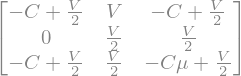

In [3]:
V,C,mu = symbols(' V C mu')

Payoff_matrix = Matrix([[V/2 - C, V, V/2-C],[0,V/2,V/2],[V/2-C,V/2,V/2-mu*C]])

Payoff_matrix

Assuming that all strategies have a base fitness of $\omega_0$ and that the effect of the interactions is factored by a selection coefficient $s$, we obtain:

In [4]:
#Variables for fitness
wh,wd,wr = symbols('omega_h omega_d omega_r')

#Parameters affecting fitness
w0,s,PD,PH = symbols('omega_0 s P_D P_H')

#Variables for fitness differences
alpha,beta = symbols('alpha beta')

wh = w0 + s*(PH*(V/2 - C)+PD*(V) + (1-PD-PH)*(V/2 - C))
wd = w0 + s*(PH*0 + PD*(V/2) + (1-PH-PD)*(V/2))
wr = w0 + s*(PH*(V/2-C)+PD*(V/2)+(1-PH-PD)*(V/2-mu*C))


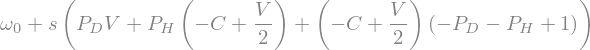

In [5]:
#fitness of hawks
wh

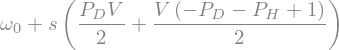

In [6]:
#fitness of doves
wd

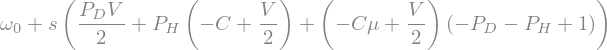

In [7]:
#fitness of reciprocators
wr

We can find the equations for nullclines - values at which two of the fitnesses are equal. Fixed points are given by the points at which all nullclines intersect.

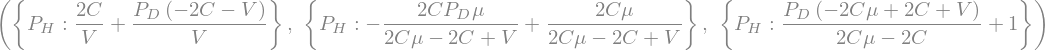

In [8]:
alpha = wh-wd
beta = wd-wr

h_d_nullcline = solve([alpha],PH,PD)
d_r_nullcline = solve([beta],PH,PD)
h_r_nullcline = solve([alpha+beta],PH,PD)


fixed_points = solve([alpha,beta],PH,PD)

h_d_nullcline, d_r_nullcline, h_r_nullcline

In [9]:
def h_d_null_func(pd,v,c,mu):
    null_sol = lambdify([V,C,PD],h_d_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd)
    pr = 1-pd-ph
    
    return (pd,ph,pr)

def d_r_null_func(pd,v,c,Mu):
    null_sol = lambdify([V,C,PD,mu],d_r_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd,Mu)
    pr = 1-pd-ph
    
    return (pd,ph,pr)

def h_r_null_func(pd,v,c,Mu):
    null_sol = lambdify([V,C,PD,mu],h_r_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd,Mu)
    pr = 1-pd-ph
    
    return (pd,ph,pr)

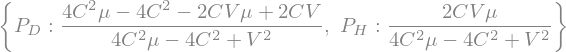

In [10]:
#Analytical solution for fixed points
fixed_points

We can find fixed points by plotting these nullclines on a simplex and looking at points of intersection: i.e plotting nullclines under the constraint that all are positive and that $P_H + P_D + P_R \leq 1$

In [45]:
def within_simplex(r):
    if r[0]+r[1]+r[2] <= 1 and r[0] >= 0 and r[1] >= 0 and r[2] >= 0:
        return True
    else:
        return False

def make_ternary_plot(V,C,mu,save=False,filename=''):
    
    pd_list = np.arange(0,1,0.01)
    
    h_d_null = []
    h_r_null = []
    d_r_null = []
    for pd in pd_list:
        
        #Get the value of the H-D null
        tuple1 = h_d_null_func(pd,V,C,mu)
        if within_simplex(tuple1):
            h_d_null.append(tuple1)
        
        #Get the value of the H-R null
        tuple2 = h_r_null_func(pd,V,C,mu)
        if within_simplex(tuple2):
            h_r_null.append(tuple2)
        
        #Get the value of the D-R null
        tuple3 = d_r_null_func(pd,V,C,mu)
        if within_simplex(tuple3):
            d_r_null.append(tuple3)
    
    figure, tax = ternary.figure(scale=1)

    fontsize = 16
    offset = 0.11
    
    #set background
    tax.set_background_color(color="#222222", alpha=0.7)
    
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=1, multiple=1)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=0.5, multiple=0.2,alpha=0.5)
    
    tax.set_title("V = "+str(V) + "\nC = " + str(C) + "\n$\mu$ = " + str(mu) + '\nV/2C = ' + str(V/(2*C)),position=(-0.05,1.5,-0.03),fontsize=18)

    tax.top_corner_label("Pure Reciprocator", fontsize=fontsize,position=(-0.1,1.2,-0.03),offset=0)
    tax.left_corner_label("Pure\nDove", fontsize=fontsize,position=(-0.05,-0.01,1.1),offset=0)
    tax.right_corner_label("Pure\nHawk", fontsize=fontsize,position=(1.05,0,-0.02),offset=0)
    tax.left_axis_label("$P_H$", fontsize=fontsize, offset=offset)
    tax.right_axis_label("$P_R$", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("$P_D$", fontsize=fontsize, offset=offset)
    
    tax.plot(h_d_null,linewidth=2.0,color='green',label='H-D nullcline')
    tax.plot(h_r_null,linewidth=2.0,color='#0047ab',label='R-H nullcline')
    tax.plot(d_r_null,linewidth=2.0,color='orange',label='D-R nullcline')
    tax.ticks(axis='lbr', fontsize=13, multiple=0.2, linewidth=0.5, tick_formats="%.1f",axes_colors={'l':'white','r':'white','b':'white'}, offset=0.02)    
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    tax.legend()
    
    if save:
        tax.savefig(str(filename+".png"))
    tax.show()   

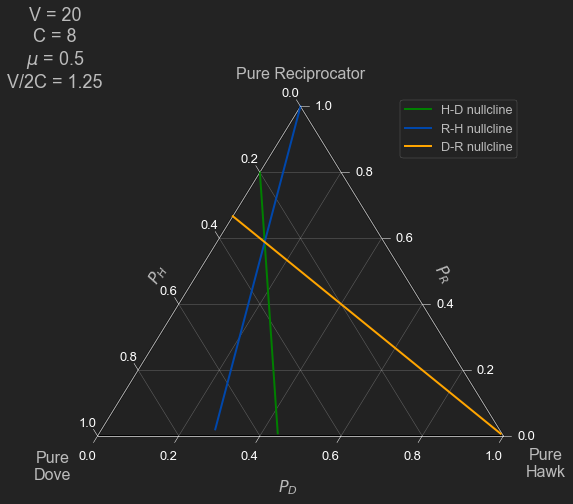

In [46]:
make_ternary_plot(20,8,0.5,save=False)

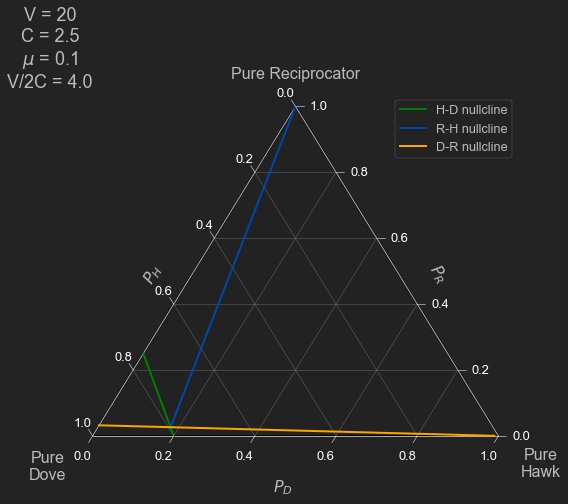

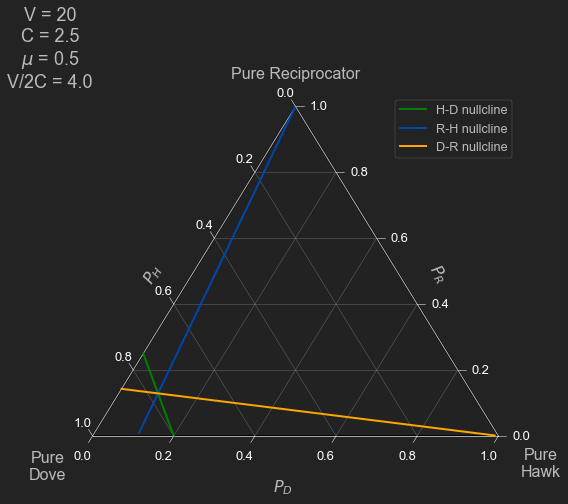

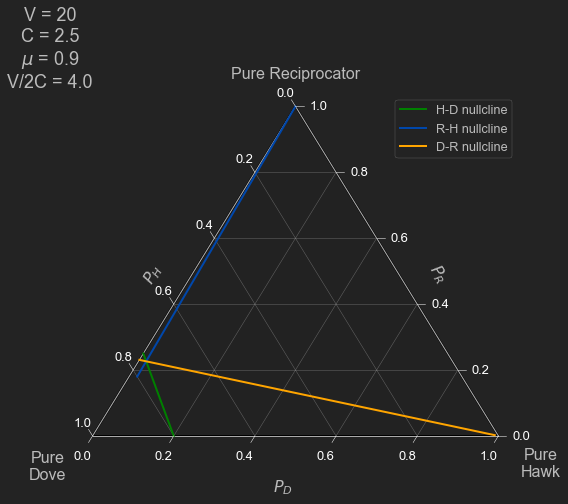

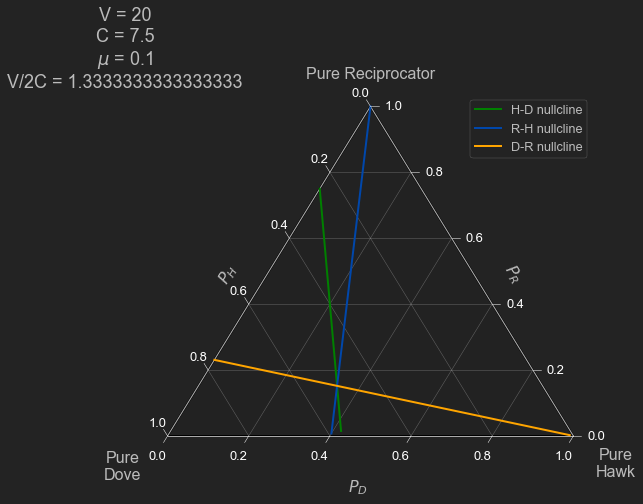

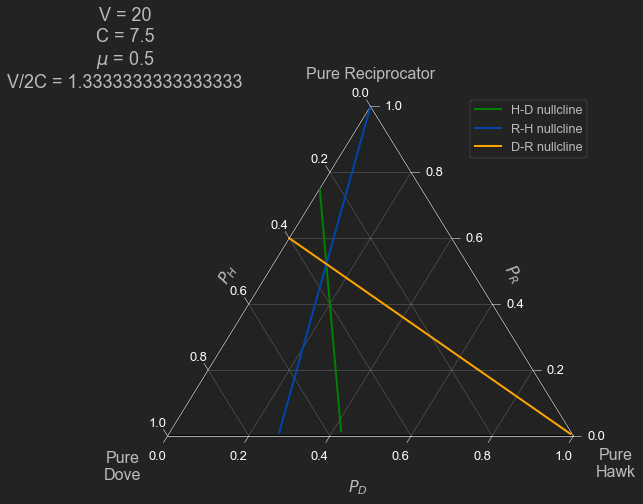

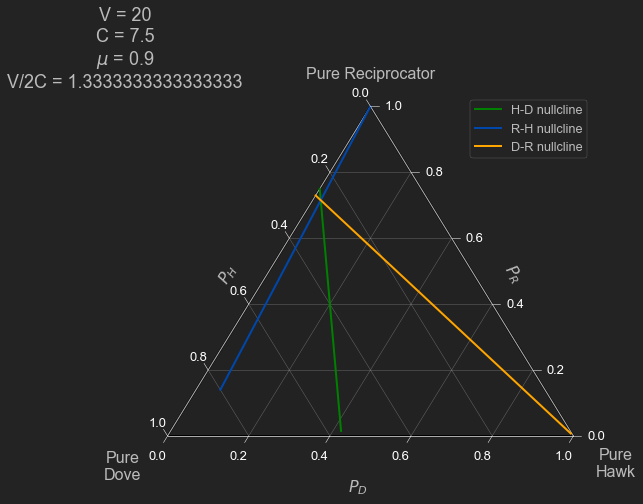

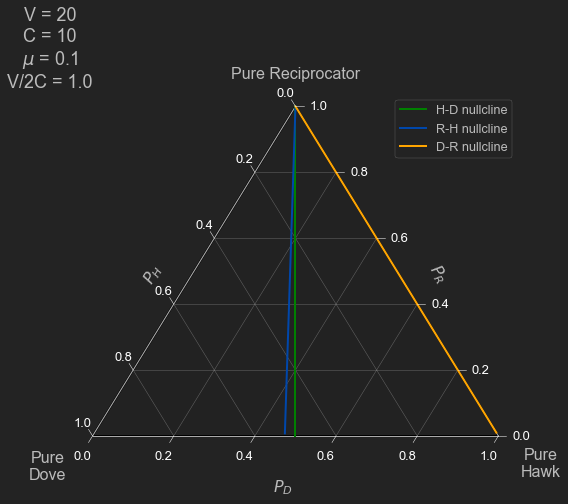

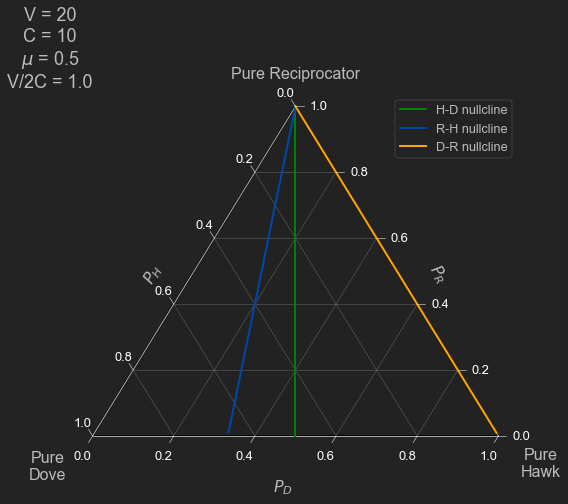

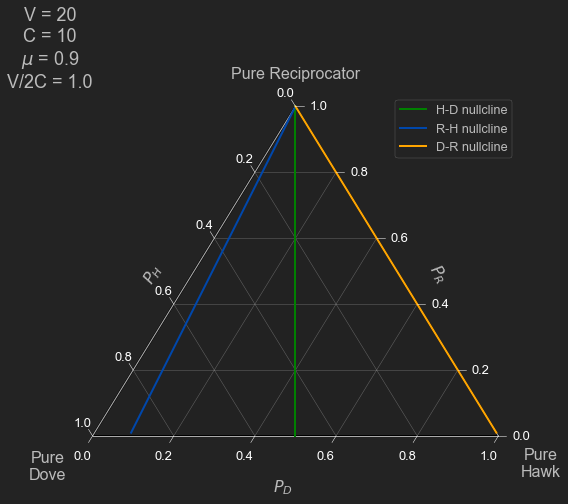

In [47]:
V_0 = 20
C_list = [2.5,7.5,10]
mu_list = [0.1,0.5,0.9]
path = '/home/shikhara/Pictures/TME/'

for i in range(3):
    for j in range(3):
        name = path+str(C_list[i])+str(mu_list[j])
        
        make_ternary_plot(V_0,C_list[i],mu_list[j],True,name)